# Linear regression


$$
\begin{align*}
    \log \sigma &\sim \text{Gaussian}(0, 1)\\
    \beta_j &\sim \text{Gaussian}(0, 1) \\
    \mu_i &= \beta_0 + \beta_1 x_i \\
    y_{i} &\sim \text{Gaussian}\left(\mu_i, \sigma^2\right) \enspace,
\end{align*}
$$

where $i=1, \ldots, n$ are the number of observations.

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '9'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [9]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from jax.scipy.stats import gaussian_kde

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import sys

from blackjax import normal_random_walk, hmc, nuts
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from bamojax.base import Model
from bamojax.samplers import gibbs_sampler, mcmc_sampler
from bamojax.inference import MCMCInference, SMCInference, VIInference, SGMCMCInference


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


Construct the model and add link functions where required. This is also needed for the Bernoulli distribution, as in distrax it can be parametrized either by probabilities or their logits, and it needs to be passed as an explicit keyword which of the two is used.

Gibbs conditionals: 
Gibbs structure:
beta                : p(y | beta, x, sigma) p(beta)
sigma               : p(y | beta, x, sigma) p(sigma)


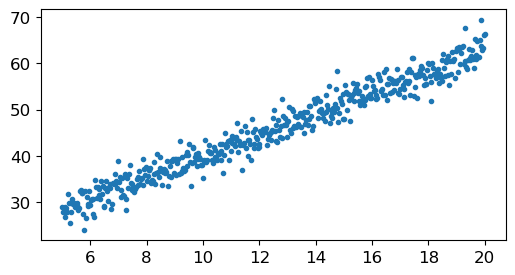

In [3]:
key = jrnd.PRNGKey(42)
key, key_data = jrnd.split(key)

b_true = [17., 2.3]
sigma_true = 2.0

n = 500

x = jnp.linspace(5, 20, n)

mu = b_true[0] + b_true[1]*x

y = mu + sigma_true*jrnd.normal(key_data, shape=(n, ))

plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.plot(x, y, '.')

def lin_reg_link_fn(beta, sigma, x):
    mu = beta[0] + beta[1]*x
    return dict(loc=mu, scale=sigma)

LinearRegression = Model('BLR')
sigma = LinearRegression.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
beta = LinearRegression.add_node('beta', distribution=dx.Normal(loc=0., scale=1.), shape=(2, ))
x_node = LinearRegression.add_node('x', observations=x)
y_node = LinearRegression.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x_node), link_fn=lin_reg_link_fn)

print('Gibbs conditionals: ')
LinearRegression.print_gibbs()

Plotting functions for the toy model posterior:

In [33]:
import numpy as np
true_values = dict(sigma=sigma_true, beta_0=b_true[0], beta_1=b_true[1])

def plot_posterior(samples, colormap, title):
    if jnp.ndim(samples['sigma']) > 1:
        num_chains = samples['sigma'].shape[0]
        colors = np.flip(colormap(np.linspace(0.3, 1, num_chains)), axis=0)
    else:
        num_chains = 1
        colors = colormap(0.5)

    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))
    varnames = ['sigma', 'beta_0', 'beta_1']
    varranges = [[1.5, 2.5], [14, 18.], [2.2, 2.7]]
    for ax, varname, varrange in zip(axes, varnames, varranges):
        input_range = jnp.linspace(*varrange, num=200)

        # 0, 1, 2, 3
        # (0, 1), (2, 3), (4, 5), (6, 7)

        if num_chains > 1:
            for c in range(num_chains):
                smpls = samples[varname][c, ...] if varname == 'sigma' else samples['beta'][c, :, int(varname[-1])]
                pdf = gaussian_kde(smpls)
                y_ = pdf(input_range)
                ax.fill_between(input_range, y_, jnp.zeros_like(y_), color=tuple(colors[c, ...]), alpha=0.7, zorder=2*c)
                ax.plot(input_range, y_, color='k', lw=0.5, zorder=2*c+1)
        else:
            smpls = samples[varname] if varname == 'sigma' else samples['beta'][:, int(varname[-1])]
            pdf = gaussian_kde(smpls)
            y_ = pdf(input_range)
            ax.fill_between(input_range, y_, jnp.zeros_like(y_), color=tuple(colors), alpha=0.7)
            ax.plot(input_range, y_, color='k', lw=0.5)
        ax.set_ylim(bottom=0)
        ax.set_xlim(*varrange)
        ax.axvline(x=true_values[varname], ls='--', color='k')
        ax.set_xlabel(fr'$\{varname}$')

    plt.suptitle(title)
    return fig, axes

#

Acceptance rate: 0.379
Effective sample sizes for RMH
ESS (beta): 191.83
ESS (sigma): 1544.21
Acceptance rate beta: 0.178
Acceptance rate sigma: 0.169
Effective sample sizes for Gibbs
ESS (beta): 296.56
ESS (sigma): 2810.08
Adapting NUTS HMC parameters
Effective sample sizes for NUTS
ESS (beta): 6178.85
ESS (sigma): 6927.83


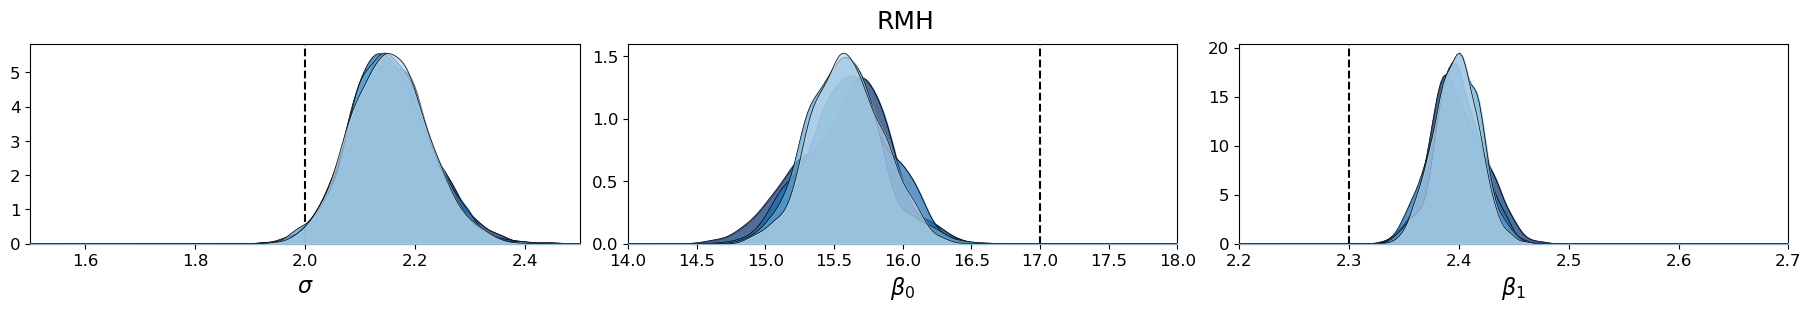

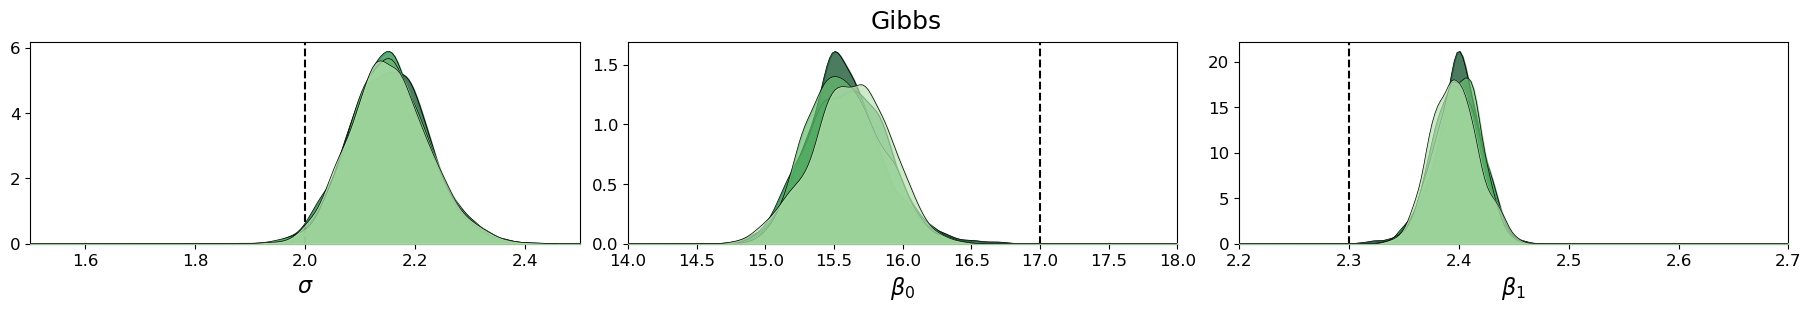

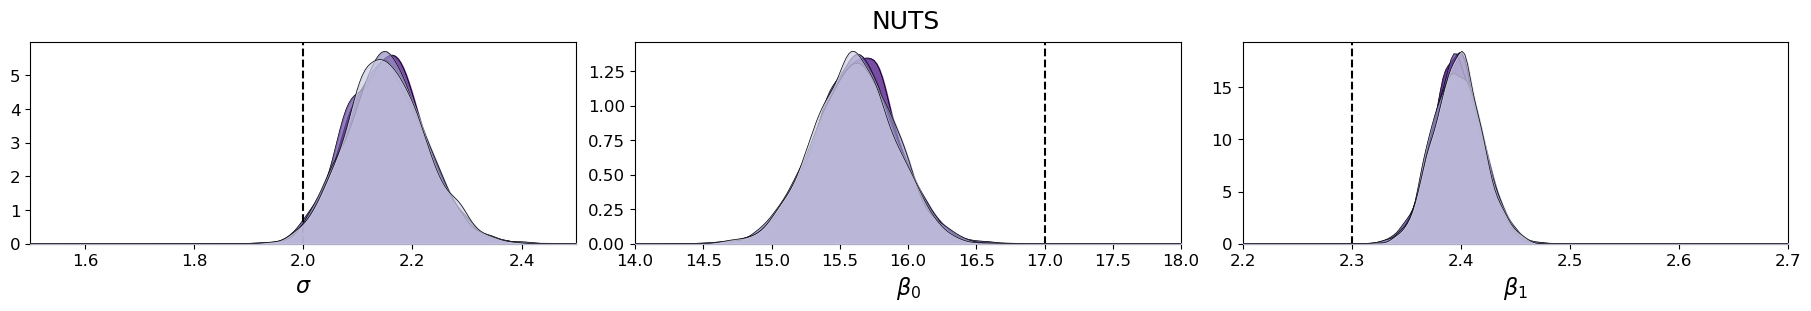

In [49]:
model = LinearRegression
m = model.get_model_size()

### RMH
rmh_parameters = dict(sigma=0.02*jnp.eye(m))
rmh_kernel = mcmc_sampler(mcmc_kernel=normal_random_walk, model=model, mcmc_parameters=rmh_parameters)

### Gibbs
step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05), sigma=dict(sigma=0.5))
gibbs_kernel = gibbs_sampler(model, step_fns=step_fns, step_fn_params=step_fn_params)

### NUTS
cold_nuts_parameters = dict(step_size=0.5, inverse_mass_matrix=0.0001*jnp.eye(m))  # these will be overriden by the window adaptation
nuts_kernel = mcmc_sampler(model=model, mcmc_kernel=blackjax.nuts, mcmc_parameters=cold_nuts_parameters)

mcmc_names = ['RMH', 'Gibbs', 'NUTS']
mcmc_kernels = [rmh_kernel, gibbs_kernel, nuts_kernel]

num_chains = 4
mcmc_settings = [dict(num_samples=100_000, num_burn=100_000, num_thin=50),
                 dict(num_samples=50_000, num_burn=50_000, num_thin=25),
                 dict(num_samples=6_000, num_burn=0, num_warmup=1_000, num_thin=3)]

mcmc_colors = ['Blues', 'Greens', 'Purples']

key = jrnd.PRNGKey(0)

for name, kernel, settings, color in zip(mcmc_names, mcmc_kernels, mcmc_settings, mcmc_colors):
    engine = MCMCInference(model=model, num_chains=num_chains, **settings, return_diagostics=True, mcmc_kernel=kernel)
    key, subkey = jrnd.split(key)
    result = engine.run(key=subkey)
    if hasattr(result['info'], 'is_accepted'):
        ar = jnp.mean(result['info'].is_accepted)
        print(f'Acceptance rate: {ar:0.3f}')
        
    if isinstance(result['info'], dict):
        for var in result['info'].keys():
            ar = jnp.mean(result['info'][var].is_accepted)
            print(f'Acceptance rate {var}: {ar:0.3f}')

    plot_posterior(result['states'], mpl.colormaps[color], title=name)
    ess = jax.tree_util.tree_map(effective_sample_size, result['states'])
    print(f'Effective sample sizes for {name}')
    for variable, var_ess in ess.items():
        mean_ess = jnp.mean(var_ess)
        print(f'ESS ({variable}): {mean_ess:0.2f}')

NUTS in SMC can be very slow!

Acceptance rate for RMH: 0.5363458395004272
Effective sample sizes for RMH
ESS (beta): 7880.32
ESS (sigma): 6212.40
Acceptance rate for Gibbs, beta: 0.4112841784954071
Acceptance rate for Gibbs, sigma: 0.3926720917224884
Effective sample sizes for Gibbs
ESS (beta): 330.87
ESS (sigma): 6343.93


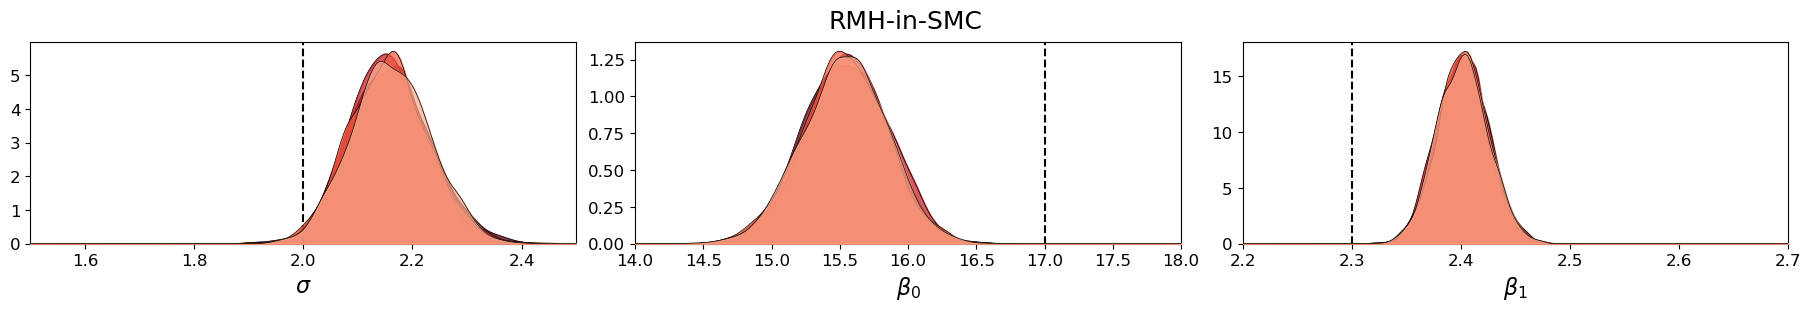

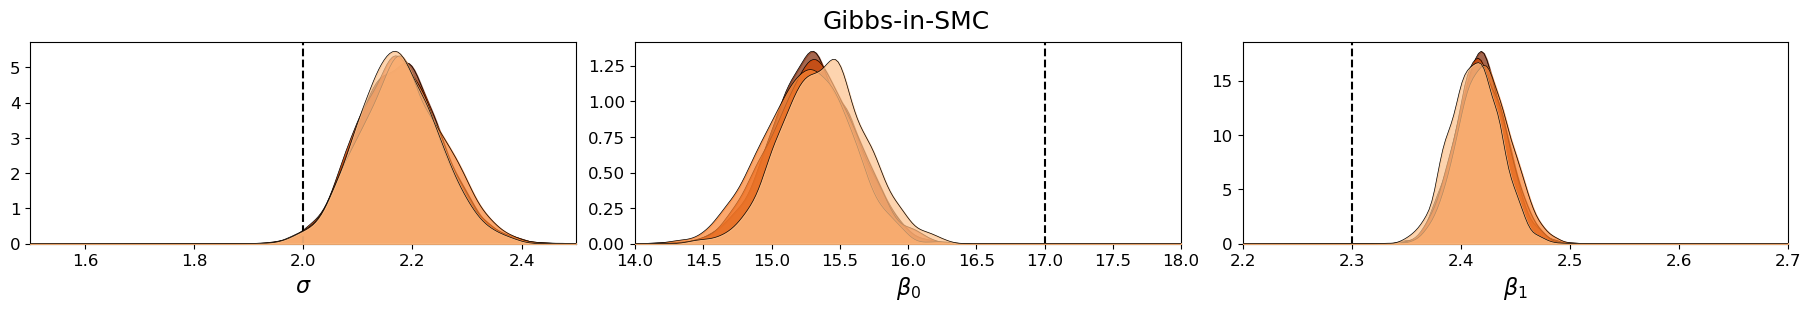

In [63]:
num_chains = 4
num_particles = 2_000

### RMH
rmh_parameters = dict(sigma=jnp.diag(jnp.array([0.1, 0.01, 0.01])))  # this vs 0.01*jnp.eye(m) makes a HUGE difference
rmh_kernel = mcmc_sampler(mcmc_kernel=normal_random_walk, model=model, mcmc_parameters=rmh_parameters)

### Gibbs
step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.02), sigma=dict(sigma=0.2))
gibbs_kernel = gibbs_sampler(model, step_fns=step_fns, step_fn_params=step_fn_params)

mcmc_names = ['RMH', 'Gibbs']
mcmc_kernels = [rmh_kernel, gibbs_kernel]

mcmc_settings = [dict(num_mutations=300),
                 dict(num_mutations=300)]

mcmc_colors = ['Reds', 'Oranges']

for name, kernel, settings, color in zip(mcmc_names, mcmc_kernels, mcmc_settings, mcmc_colors):
    engine = SMCInference(model=model, num_chains=num_chains, return_diagnostics=True, mcmc_kernel=kernel, **settings, num_particles=num_particles)
    key, subkey = jrnd.split(key)
    result = engine.run(key=subkey)

    if name == 'RMH':
        ar = jnp.mean(result['final_info'].update_info.is_accepted)
        print(f'Acceptance rate for {name}: {ar}')
    if name == 'Gibbs':
        for var, value in result['final_info'].update_info.items():
            ar = jnp.mean(value.is_accepted)
            print(f'Acceptance rate for {name}, {var}: {ar}')

    plot_posterior(result['final_state'].particles, mpl.colormaps[color], title=f'{name}-in-SMC')
    ess = jax.tree_util.tree_map(effective_sample_size, result['final_state'].particles)
    print(f'Effective sample sizes for {name}')
    for variable, var_ess in ess.items():
        mean_ess = jnp.mean(var_ess)
        print(f'ESS ({variable}): {mean_ess:0.2f}')

# Posterior predictive

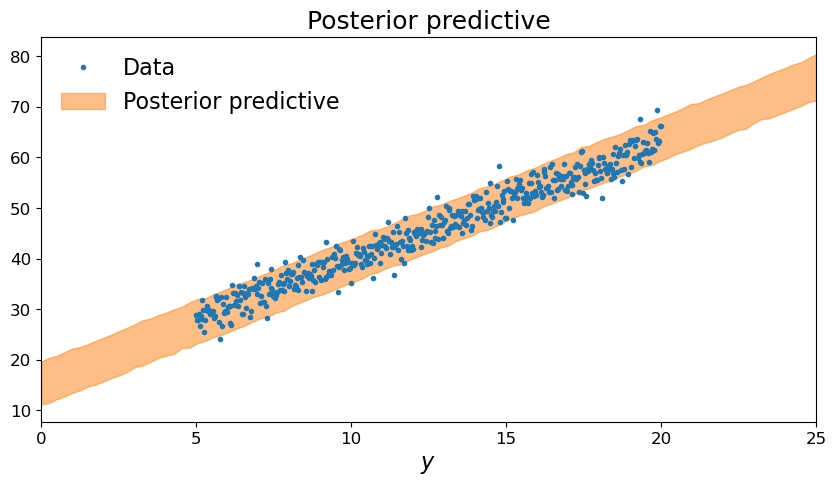

In [64]:
n_pred = 100
x_pred_lim = [0, 25]
x_pred = jnp.linspace(*x_pred_lim, n_pred)

smpls = jax.tree_util.tree_map(lambda x: jnp.squeeze(x[0, ...]), result['final_state'].particles)
keys = jrnd.split(key, num_particles)

# We could do this with a partial too
def wrapper(key, smpl):
    return model.sample_posterior_predictive(key, smpl, dict(x=x_pred))

#

predictions = jax.vmap(wrapper)(keys, smpls)

plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.plot(x, y, '.', label='Data')
y_lb, y_ub = jnp.quantile(predictions['y'], q=jnp.array([0.025, 0.975]), axis=0)
ax.fill_between(x_pred, y_lb, y_ub, color='tab:orange', alpha=0.5, label='Posterior predictive')
ax.set_xlabel(r'$x$')
ax.set_xlabel(r'$y$')
ax.set_xlim(*x_pred_lim)
ax.set_title('Posterior predictive')
ax.legend(frameon=False);

# Variational inference

Note: blackjax initializes every meanfield variational distribution in the same way; by setting all means $\mu=0$ and all variances to $\rho=\exp(-2)$. This prevents us from doing an appropriate convergence check.

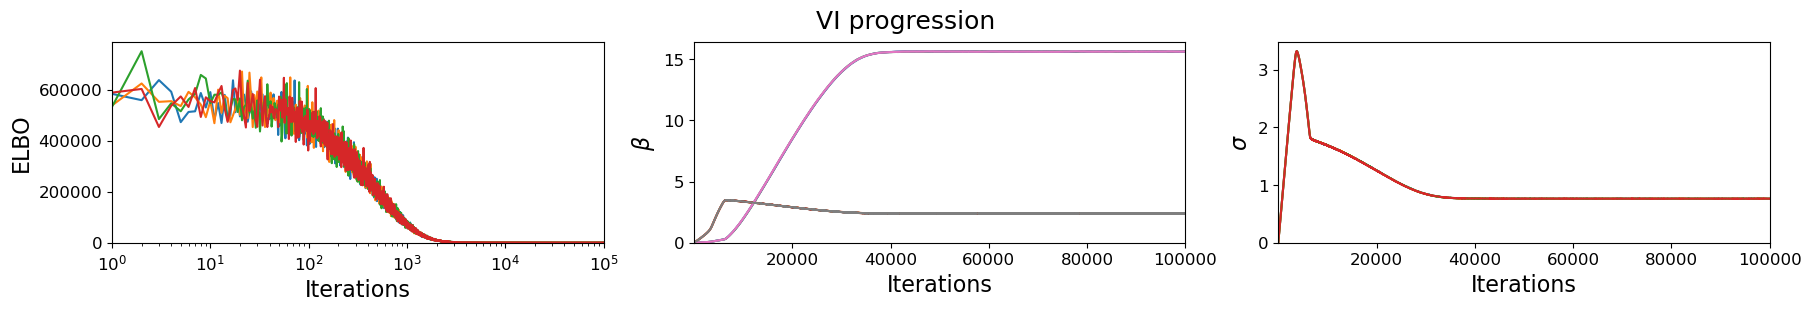

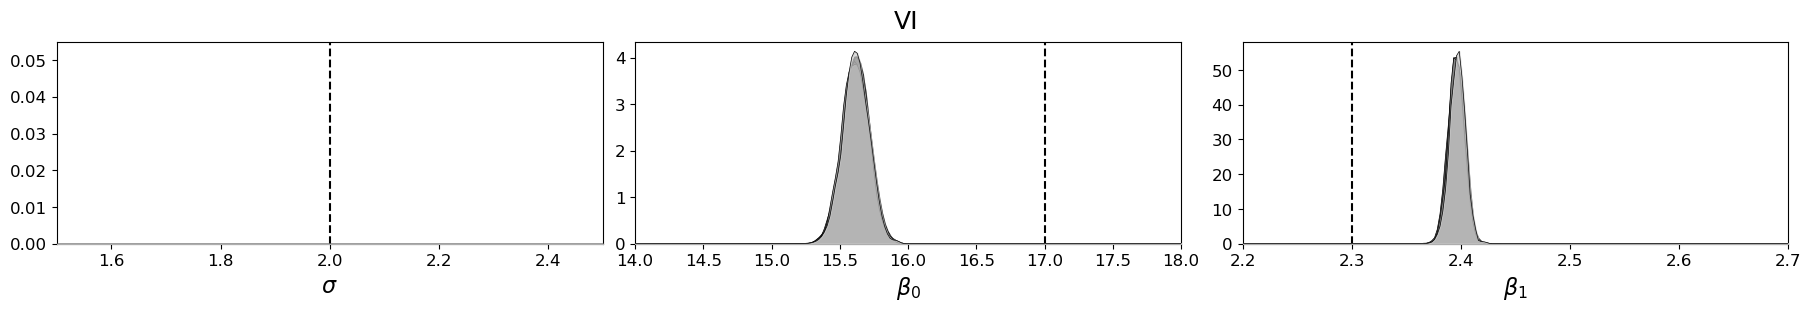

In [36]:
import optax

num_chains = 4
num_steps = 100_000
num_gradient_samples = 10

engine = VIInference(model, 
                     num_chains=num_chains, 
                     num_steps=num_steps, 
                     num_gradient_samples=num_gradient_samples, 
                     optimizer=optax.sgd(learning_rate=1e-3), 
                     optimizer_chain_args=optax.clip_by_global_norm(1.0))

result = engine.run(key=jrnd.PRNGKey(0))

_, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))

for c in range(num_chains):
    axes[0].plot(jnp.arange(num_steps), jnp.asarray(result['info'].elbo[c, ...]))
    axes[1].plot(jnp.arange(num_steps), result['states'].mu['beta'][c, ...])
    axes[2].plot(jnp.arange(num_steps), result['states'].mu['sigma'][c, ...])
axes[0].set_ylabel('ELBO')
axes[0].set_xscale('log')

axes[1].set_ylabel(r'$\beta$')
axes[2].set_ylabel(r'$\sigma$')
for ax in axes:    
    ax.set_xlabel('Iterations')
    ax.set_xlim([1, num_steps])
    ax.set_ylim(bottom=0)
plt.suptitle('VI progression')

vi_samples = engine.sample_from_variational(jrnd.PRNGKey(0), vi_result=result, num_draws=2_000)
plot_posterior(vi_samples, mpl.colormaps['Greys'], title='VI');

Note:
- Sometimes the ELBO seems to converge, while parameter estimates still change (significantly).
- VI substantially underestimates the observation noise.

# Stochastic-gradient MCMC

What are reasonable HMC parameters?

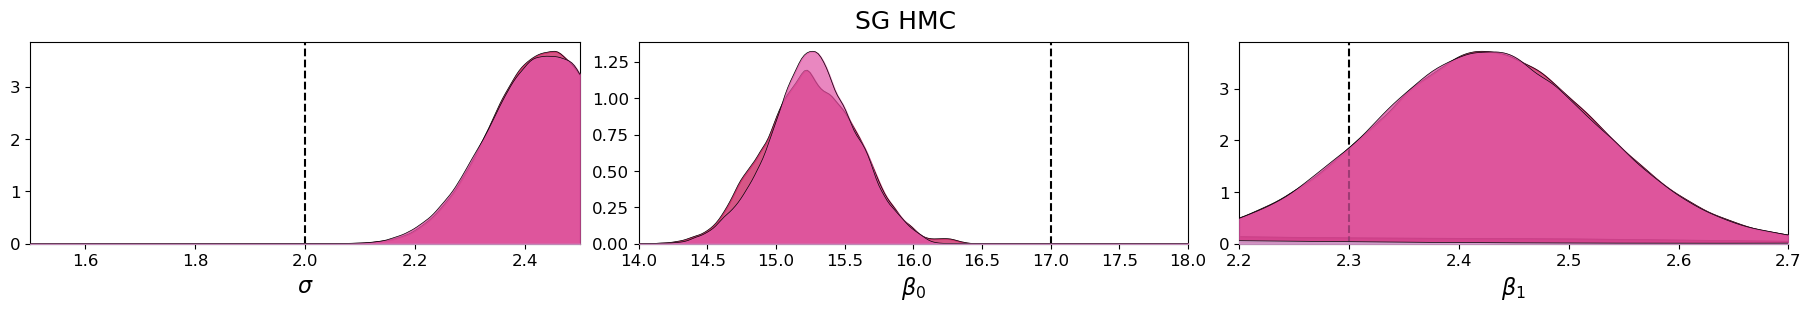

In [ ]:
batch_size = 25
num_burn = 100_000
num_thin = 10
num_samples = 100_000
num_chains = 4
stepsize = 1e-3

engine = SGMCMCInference(model=model, 
                         num_chains=num_chains, 
                         sgmcmc_kernel=blackjax.sghmc, 
                         sgmcmc_params=dict(num_integration_steps=10, alpha=0.01, beta=0.0), 
                         data_size=n, 
                         batch_size=batch_size, 
                         batch_nodes=[x_node, y_node], 
                         stepsize=stepsize, 
                         num_samples=num_samples, 
                         num_burn=num_burn, 
                         num_thin=num_thin)

result = engine.run(jrnd.PRNGKey(0))

plot_posterior(result['states'], mpl.colormaps['PuRd'], title='SG HMC');

Text(0, 0.5, '$\\sigma$')

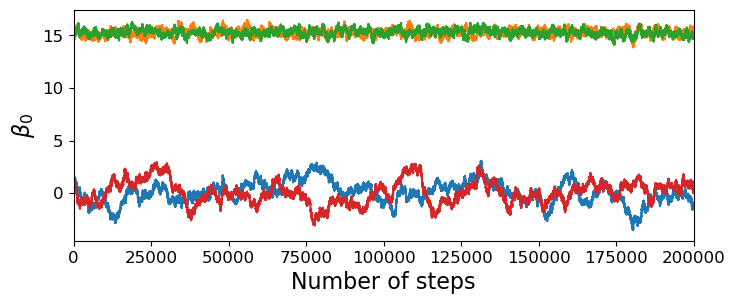

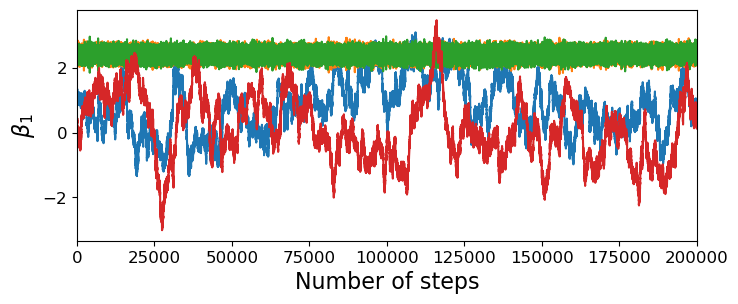

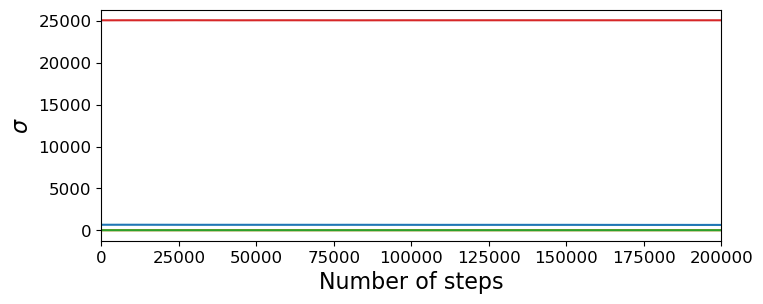

In [44]:
plt.figure(figsize=(8, 3))
for c in range(num_chains):
    plt.plot(result['states']['beta'][c, :, 0])
plt.xlim([0, num_samples])
plt.xlabel('Number of steps')
plt.ylabel(r'$\beta_0$')

plt.figure(figsize=(8, 3))
for c in range(num_chains):
    plt.plot(result['states']['beta'][c, :, 1])
plt.xlim([0, num_samples])
plt.xlabel('Number of steps')
plt.ylabel(r'$\beta_1$')

plt.figure(figsize=(8, 3))
for c in range(num_chains):
    plt.plot(result['states']['sigma'][c, :])
plt.xlim([0, num_samples])
plt.xlabel('Number of steps')
plt.ylabel(r'$\sigma$')

While fast per iteration, these approaches can be less robust and are hard to get to converge. Mostly useful for high-dimensional models like BNNs.